In [1]:
# --- Standard libraries
import pickle as pkl
import numpy as np
# --- PyTorch
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
# --- NetworkX
import networkx as nx
# --- RDKit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 300,300
# --- Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# --- Modules from local files
from GNN.GNN_mol import GNN
from Dataset import XASDataset
from utils.train import train_model
from utils.test import test_model
from utils.utils import plot_learning_curve

#### Import dataset

In [2]:
# --- Path raw directory containing the data
path = "./"
# --- Load and create the dataset
dataset = XASDataset(path)

In [3]:
# --- Show detail of the dataset
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print('')

# --- Show details of the first molecule/graph in dataset
data = dataset[0]

print(data)
print('------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

XASDataset(317)
------------
Number of graphs: 317
Number of features: 15
Number of classes: 0

Data(x=[32, 15], edge_index=[2, 76], edge_attr=[76, 6], spectrum=[200], pos=[32, 3], z=[32], idx=[1], smiles='c12[c:2]3[cH:1][cH:25][c:24]4[c:22]1[c:17]1[c:19]([cH:20][cH:23]4)[C:18]([C:21](=[O:26])[OH:27])=[CH:16][C:15]4=[CH:14][CH:12]=[C:11]5[C:9]([OH:30])([CH:4]2[C:6]([OH:31])([C:5]([C:8](=[O:28])[OH:29])=[CH:3]3)[CH:7]=[CH:10]5)[CH:13]41')
------------
Number of nodes: 32
Number of edges: 76
Average node degree: 2.38
Has isolated nodes: False
Has self loops: False
Is undirected: True


In [4]:
torch.save(dataset, './datasets/mol_dataset.pt')

#### View data

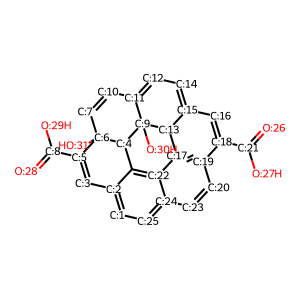

In [5]:
mol = Chem.MolFromSmiles(data.smiles)
mol

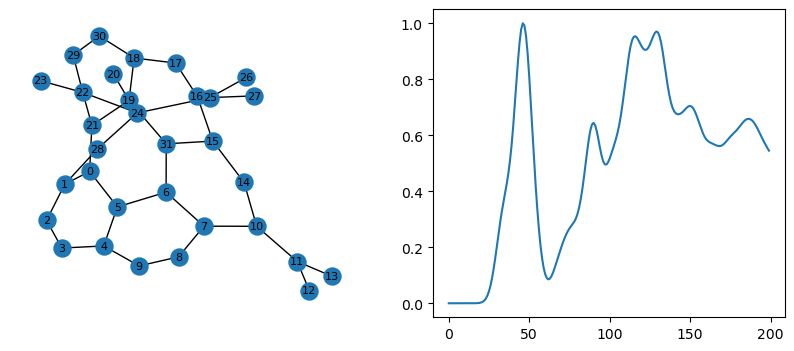

In [6]:
# --- Create subplot for plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# --- Show graph representation of molecule
mol_graph = to_networkx(data, to_undirected=True)
nx.draw(mol_graph, ax=ax1, with_labels=True, node_size=150, font_size=8)

# --- Show molecule spectrum
ax2.plot(data.spectrum)
plt.show()

#### Split up dataset

In [8]:
# --- Split data into test, validation and test
train_dataset = dataset[0:238]
val_dataset = dataset[239:268]
test_dataset = dataset[269:]

# --- Pass into dataloader
train_loader = DataLoader(train_dataset, batch_size=238, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=29, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=48, shuffle=False)

print(f'Length of training data loader: {len(train_loader.dataset)}, with a total of {len(train_loader)} datassets')
print(f'Length of validation data loader: {len(val_loader.dataset)}, with a total of {len(val_loader)} datasets')
print(f'Length of testing data loader: {len(test_loader.dataset)}, with a total of {len(test_loader)} datasets')

Length of training data loader: 238, with a total of 1 datassets
Length of validation data loader: 29, with a total of 1 datasets
Length of testing data loader: 48, with a total of 1 datasets


In [9]:
torch.save(test_dataset, './datasets/mol_test_dataset.pt')

#### Set neural network properties

In [117]:
num_tasks = 200
num_layers = 3
emb_dim = dataset.num_features
in_channels = [int(emb_dim), 64, 128]
out_channels = [64, 128, 256]
gnn_type = "gcn"
heads = int(1)
drop_ratio = 0.35
graph_pooling = "mean"

In [118]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
model = model.to(device)
print(model)
print('----')
print(f'Training will be performed on: {device}')

GNN(
  (gnn_node): GNN_node(
    (convs): ModuleList(
      (0): GCNConv(15, 64)
      (1): GCNConv(64, 128)
      (2): GCNConv(128, 256)
    )
    (batch_norms): ModuleList(
      (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (graph_pred_linear): Linear(in_features=256, out_features=200, bias=True)
)
----
Training will be performed on: cuda


In [119]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=100, min_lr=0.000001)

#### Run neural network training

In [120]:
num_epochs = 500
best_val_error = None
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    loss = train_model(epoch, train_loader, model, device, optimizer)

    val_error = test_model(val_loader, model, device)

    scheduler.step(val_error)

    train_losses.append(loss)

    val_losses.append(val_error)

    current_lr = optimizer.param_groups[0]["lr"]

    if best_val_error is None or val_error <= best_val_error:

        best_val_error = val_error

    if epoch % 25 == 0:
        print(f"Epoch: {epoch:03d}, LR: {current_lr:7f}, TrainLoss: {loss:.7f}, ValLoss: {val_error:7f}, Best_ValLoss: {best_val_error:7f}")

print(f'Final trianing loss value of: {loss} and validation loss of: {val_error}')

Epoch: 000, LR: 0.001000, TrainLoss: 0.2524569, ValLoss: 0.308495, Best_ValLoss: 0.308495
Epoch: 025, LR: 0.001000, TrainLoss: 0.1789532, ValLoss: 0.083999, Best_ValLoss: 0.083999
Epoch: 050, LR: 0.001000, TrainLoss: 0.1194549, ValLoss: 0.143865, Best_ValLoss: 0.082907
Epoch: 075, LR: 0.001000, TrainLoss: 0.0221412, ValLoss: 0.199941, Best_ValLoss: 0.082907
Epoch: 100, LR: 0.001000, TrainLoss: 0.0156965, ValLoss: 0.010460, Best_ValLoss: 0.010460
Epoch: 125, LR: 0.001000, TrainLoss: 0.0134485, ValLoss: 0.009085, Best_ValLoss: 0.009001
Epoch: 150, LR: 0.001000, TrainLoss: 0.0119351, ValLoss: 0.009092, Best_ValLoss: 0.008948
Epoch: 175, LR: 0.001000, TrainLoss: 0.0119283, ValLoss: 0.009227, Best_ValLoss: 0.008827
Epoch: 200, LR: 0.001000, TrainLoss: 0.0115171, ValLoss: 0.008625, Best_ValLoss: 0.008625
Epoch: 225, LR: 0.001000, TrainLoss: 0.0106907, ValLoss: 0.008838, Best_ValLoss: 0.008612
Epoch: 250, LR: 0.001000, TrainLoss: 0.0113249, ValLoss: 0.008988, Best_ValLoss: 0.008612
Epoch: 275

In [121]:
model_name = 'model_gnn_mol_21.pt'
torch.save(model.state_dict(), "ML_models/" + model_name)

#### View loss

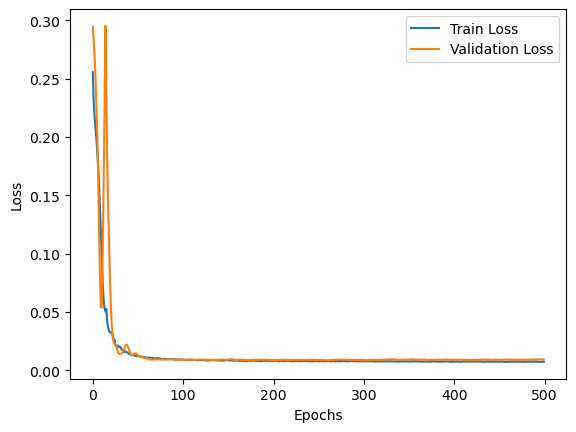

In [16]:
plot_learning_curve(num_epochs, train_losses, val_losses)